# NII - FBX

In [1]:
import SimpleITK as sitk
import numpy as np

images = []

for num in [915, 925, 935, 945, 955, 995]:
    img = sitk.ReadImage(f'./Heart/Predicted_NIfTI_masks/heart_{num}.nii.gz')
    arr = sitk.GetArrayFromImage(img)
    images.append(arr)
print("Finished Loading Images")

print("\nSanity size Check")
for i in images:
    print(i.shape)

Finished Loading Images

Sanity size Check
(256, 512, 512)
(256, 512, 512)
(256, 512, 512)
(256, 512, 512)
(256, 512, 512)
(256, 512, 512)


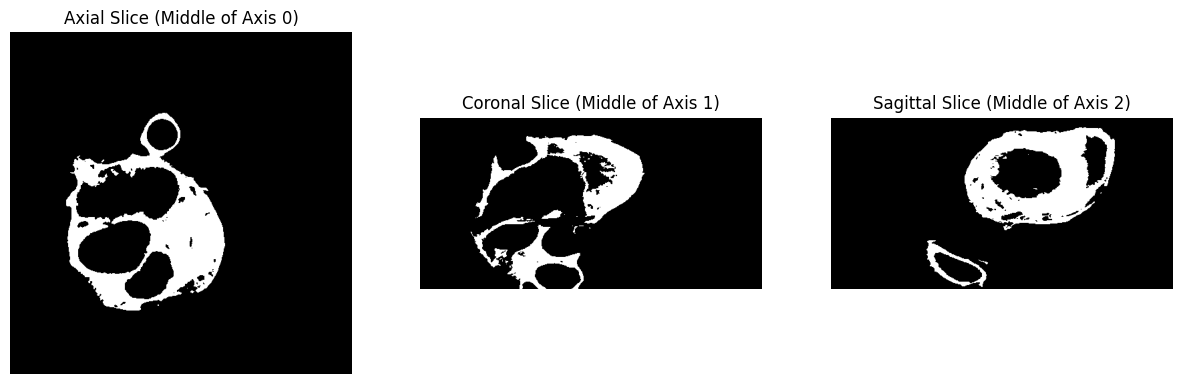

In [2]:
import matplotlib.pyplot as plt

# Assuming images[0] is a 3D Numpy array
data = images[0]

# Visualizing a slice from the middle along each axis
plt.figure(figsize=(15, 5))

# Slice along the axial plane (axis 0)
plt.subplot(1, 3, 1)
plt.title("Axial Slice (Middle of Axis 0)")
plt.imshow(data[data.shape[0] // 2, :, :], cmap="gray")
plt.axis('off')

# Slice along the coronal plane (axis 1)
plt.subplot(1, 3, 2)
plt.title("Coronal Slice (Middle of Axis 1)")
plt.imshow(data[:, data.shape[1] // 2, :], cmap="gray")
plt.axis('off')

# Slice along the sagittal plane (axis 2)
plt.subplot(1, 3, 3)
plt.title("Sagittal Slice (Middle of Axis 2)")
plt.imshow(data[:, :, data.shape[2] // 2], cmap="gray")
plt.axis('off')

plt.show()


In [ ]:
# Perform demons registration between first image (915) and second image (925)
voxels1_int = images[0].astype(int)
voxels2_int = images[1].astype(int)

img1 = sitk.GetImageFromArray(voxels1_int)
img2 = sitk.GetImageFromArray(voxels2_int)

# Initialize the Demons Registration filter
demons_filter = sitk.DemonsRegistrationFilter()
demons_filter.SetNumberOfIterations(100)  # Number of iterations
demons_filter.SetSmoothDisplacementField(True)  # Enable smoothing
demons_filter.SetStandardDeviations(2.0)  # Adjust smoothing level

print("About to do perform registration")
# Perform registration to get the displacement field
displacement_field = demons_filter.Execute(img1, img2)

print("Displacement field size:", displacement_field.GetSize())

if displacement_field.GetSize() != (0, 0):
    # Apply the displacement field to get the deformed image
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(img1)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(sitk.DisplacementFieldTransform(displacement_field))

    # Get the transformed (registered) image
    transformed_img = resampler.Execute(img2)
    print("Done transforming images!")

    # Convert the displacement field and transformed image back to numpy arrays
    displacement_field_array = sitk.GetArrayFromImage(displacement_field)
    transformed_img_array = sitk.GetArrayFromImage(transformed_img)

    print("Registration done!")
    print("Displacement field shape:", displacement_field_array.shape)
    print("Transformed image shape:", transformed_img_array.shape)
else:
    print("Registration failed. Please check input data and parameters.")


About to do perform registration
Displacement field size: (512, 512, 256)
Done transforming images!
Registration done!
Displacement field shape: (0, 0)
Transformed image shape: (256, 512, 512)


In [3]:
import numpy as np

mae = np.mean(np.abs(images[1] - transformed_img_array))
print("Generated VS After:", mae)
mae1 = np.mean(np.abs(transformed_img_array - images[0]))
print("Generated VS Before:", mae1)
mae2 = np.mean(np.abs(images[1] - images[0]))
print("Before VS After:", mae2)

NameError: name 'transformed_img_array' is not defined

In [4]:
from skimage import measure

# Perform Marching Cubes
verts, faces, normals, _ = measure.marching_cubes(voxels1_int, level=0.5)
print("Done")

NameError: name 'voxels1_int' is not defined

In [4]:
import fbx
from skimage import measure
import nibabel as nib
from scipy.ndimage import gaussian_filter

# Load the NIfTI file
voxel_data = images[0].astype(int)
# voxel_data = transformed_img_array

# Can choose to apply gaussian filter
# smoothed_data = gaussian_filter(voxel_data, sigma=1)  # Adjust sigma for smoothing intensity
# verts, faces, normals, _ = measure.marching_cubes(smoothed_data, level=0.3)
verts, faces, normals, _ = measure.marching_cubes(voxel_data, level=0.3)

# Initialize the FBX SDK
manager = fbx.FbxManager.Create()
scene = fbx.FbxScene.Create(manager, "MyScene")

# Create a mesh object
mesh = fbx.FbxMesh.Create(scene, "MyMesh")

# Set the vertices in the FBX mesh
mesh.InitControlPoints(len(verts))
for i, vert in enumerate(verts):
    mesh.SetControlPointAt(fbx.FbxVector4(*vert), i)

# Add polygons to the mesh
for face in faces:
    mesh.BeginPolygon()
    for idx in face:
        mesh.AddPolygon(idx)
    mesh.EndPolygon()

# Create a node for the mesh
mesh_node = fbx.FbxNode.Create(scene, "MyMeshNode")
mesh_node.SetNodeAttribute(mesh)

# Add the mesh node to the scene
scene.GetRootNode().AddChild(mesh_node)

# Export the scene to an FBX file
exporter = fbx.FbxExporter.Create(manager, "")
exporter.Initialize("output_path.fbx", -1, manager.GetIOSettings())
exporter.Export(scene)
exporter.Destroy()
manager.Destroy()
print("Single Warped FBX")


Single Warped FBX


### Generating settings and nodes for FBX

In [4]:
import fbx
from skimage import measure

# Initialize the FBX SDK
manager = fbx.FbxManager.Create()
scene = fbx.FbxScene.Create(manager, "HeartAnimationScene")

# Create the animation stack and layer
anim_stack = fbx.FbxAnimStack.Create(scene, "HeartAnimationStack")
anim_layer = fbx.FbxAnimLayer.Create(scene, "HeartAnimationLayer")
anim_stack.AddMember(anim_layer)

# Function to create a mesh node from voxel data
def create_heart_mesh_node(voxel_data, scene, name):
    verts, faces, normals, _ = measure.marching_cubes(voxel_data, level=0.3)
    
    mesh = fbx.FbxMesh.Create(scene, name)
    mesh.InitControlPoints(len(verts))
    
    # Set vertices
    for i, vert in enumerate(verts):
        mesh.SetControlPointAt(fbx.FbxVector4(*vert), i)

    # Set faces
    for face in faces:
        mesh.BeginPolygon()
        for idx in face:
            mesh.AddPolygon(idx)
        mesh.EndPolygon()
    
    # Create a node for the mesh and return
    mesh_node = fbx.FbxNode.Create(scene, name)
    mesh_node.SetNodeAttribute(mesh)
    return mesh_node

# Assuming transformed_img_arrays is a list of six voxel data arrays for each heart model
heart_models = [images[0].astype(int), images[1].astype(int), images[2].astype(int), 
                images[3].astype(int), images[4].astype(int), images[5].astype(int)]

# Create a node for each heart model and add to the scene
mesh_nodes = []
for i, voxel_data in enumerate(heart_models):
    mesh_node = create_heart_mesh_node(voxel_data, scene, f"HeartMeshNode_{i+1}")
    scene.GetRootNode().AddChild(mesh_node)
    mesh_nodes.append(mesh_node)

print("Finished adding mesh nodes")


Finished adding mesh nodes


In [3]:
import fbx
from skimage import measure

# Initialize the FBX SDK
manager = fbx.FbxManager.Create()
scene = fbx.FbxScene.Create(manager, "HeartScene")

# Create an empty parent node
parent_node = fbx.FbxNode.Create(scene, "ParentNode")
scene.GetRootNode().AddChild(parent_node)

# Function to create a mesh node from voxel data
def create_heart_mesh_node(voxel_data, scene, name):
    verts, faces, normals, _ = measure.marching_cubes(voxel_data, level=0.3)
    
    mesh = fbx.FbxMesh.Create(scene, name)
    mesh.InitControlPoints(len(verts))
    
    # Set vertices
    for i, vert in enumerate(verts):
        mesh.SetControlPointAt(fbx.FbxVector4(*vert), i)
    
    # Set faces
    for face in faces:
        mesh.BeginPolygon()
        for idx in face:
            mesh.AddPolygon(idx)
        mesh.EndPolygon()
    
    # Create a node for the mesh and return
    mesh_node = fbx.FbxNode.Create(scene, name)
    mesh_node.SetNodeAttribute(mesh)
    return mesh_node

# Assuming transformed_img_arrays is a list of six voxel data arrays for each heart model
heart_models = [
    images[0].astype(int),
    images[1].astype(int),
    images[2].astype(int),
    images[3].astype(int),
    images[4].astype(int),
    images[5].astype(int),
]

# Create a node for each heart model and add to the parent node
for i, voxel_data in enumerate(heart_models):
    mesh_node = create_heart_mesh_node(voxel_data, scene, f"HeartMeshNode_{i+1}")
    parent_node.AddChild(mesh_node)

print("Finished adding mesh nodes to parent node")

# Export the scene to an FBX file
exporter = fbx.FbxExporter.Create(manager, "")
output_path = "heart_scene.fbx"

# Initialize the exporter
if not exporter.Initialize(output_path, -1, manager.GetIOSettings()):
    print("Failed to initialize exporter.")
    exit()

# Export the scene
exporter.Export(scene)
exporter.Destroy()

print(f"FBX file exported successfully: {output_path}")


Finished adding mesh nodes to parent node
FBX file exported successfully: heart_scene.fbx


In [ ]:
import fbx
from skimage import measure

# Initialize the FBX SDK
manager = fbx.FbxManager.Create()
scene = fbx.FbxScene.Create(manager, "HeartAnimationScene")

# Create the animation stack and layer
anim_stack = fbx.FbxAnimStack.Create(scene, "HeartAnimationStack")
anim_layer = fbx.FbxAnimLayer.Create(scene, "HeartAnimationLayer")
anim_stack.AddMember(anim_layer)

# Function to create a mesh layer from voxel data
def create_heart_mesh_layer(voxel_data, name):
    verts, faces, normals, _ = measure.marching_cubes(voxel_data, level=0.3)
    
    # Create a new FBX mesh
    mesh = fbx.FbxMesh.Create(scene, name)
    mesh.InitControlPoints(len(verts))
    
    # Set vertices
    for i, vert in enumerate(verts):
        mesh.SetControlPointAt(fbx.FbxVector4(*vert), i)

    # Set faces
    for face in faces:
        mesh.BeginPolygon()
        for idx in face:
            mesh.AddPolygon(idx)
        mesh.EndPolygon()
    
    return mesh

# Assuming transformed_img_arrays is a list of six voxel data arrays for each heart model
heart_models = [
    images[0].astype(int),
    images[1].astype(int),
    images[2].astype(int),
    images[3].astype(int),
    images[4].astype(int),
    images[5].astype(int),
]

# Create a single parent mesh node to hold all sub-meshes
parent_mesh_node = fbx.FbxNode.Create(scene, "HeartModel")

# Create layers for each heart model and add to the parent mesh
for i, voxel_data in enumerate(heart_models):
    mesh_layer = create_heart_mesh_layer(voxel_data, f"HeartMeshLayer_{i+1}")
    mesh_node = fbx.FbxNode.Create(scene, f"HeartMeshLayer_{i+1}")
    mesh_node.SetNodeAttribute(mesh_layer)
    
    # Add this mesh as a child of the parent node
    parent_mesh_node.AddChild(mesh_node)

# Add the parent mesh node to the scene
scene.GetRootNode().AddChild(parent_mesh_node)

# Export the scene to an FBX file
exporter = fbx.FbxExporter.Create(manager, "")
output_path = "heart_one_node.fbx"

if not exporter.Initialize(output_path, -1, manager.GetIOSettings()):
    print("Failed to initialize exporter.")
    exit()

# Export the scene
exporter.Export(scene)
exporter.Destroy()

print(f"FBX file exported successfully: {output_path}")
